# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


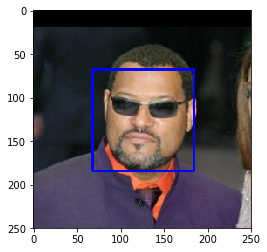

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ As the cell below shows, the `face_detector` function is pretty reliable when it comes to identifying faces as it achieves 99% accuracy. However 12% of dog pictures are missperceived to be showing a human face.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_counter = 0
dog_counter = 0

for i, human, dog in zip(range(len(human_files_short)), human_files_short, dog_files_short):

    # check for human faces
    if face_detector(human):
        human_counter += 1
    else:
        print('The human picture with index {} is missed!'.format(i))

    # check for dog faces
    dog_counter += 1 if face_detector(dog) else 0
    

print()
print('The sample of 100 images indicates that {0:.2f}% of human faces are detected.'.format(human_counter))
print('The sample of 100 images indicates that {0:.2f}% of dog faces are detected as human.'.format(dog_counter))

The human picture with index 0 is missed!

The sample of 100 images indicates that 99.00% of human faces are detected.
The sample of 100 images indicates that 12.00% of dog faces are detected as human.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ To be honest i am not sure how strongly "the algorithmic choice necessitates that we communicate that we accept human images only when they provide a clear view of a face" since the algorithm achieves 99% in this set of images that was tried above, which means that at least in terms of False Rejection Rate (1.00%), the function is better than acceptable. However that is not he case for False Acceptance Rate (12.00%) or probably in the cases of some strangly lit pictures etc. 

Entering the problem, i thought of two ways right away that could bring an improvement. The first was an example i had in mind with PCA called eigenfaces [1], and the second probably some pre-trained NN model (with a set similar to imagenet) that i could find online; and since we are on the DL part of the course i decided to go with the second.

Digging deeper into the problem i found a pretrained network on face data that was build for face recognition based on the vgg architecture that was also on keras [2]. However i could not use it straight away given that it was for recognition and not detection meaning that it had a database of faces with their names and it was doing multi-class classification, instead of two-class classification which is the detection problem. Given that, i tried to use transfer learning and use a portion of the dog pictures and a portion of human pictures that are used for other tasks in this assignment to train a Densly connected layer i could attach on top of the vgg network. That would hopefully make it a better face-dog detector than the one proposed earlier. It would probaly fail in other kinds of pictures (e.g. if a goat was presented), but i wanted to experiment and see if that could work given that the task was optional and not very well defined as to the course of action that could be followed.

Therefore, i wrote some code in a couple of cells below and also tried to combine code from other tasks of this assignment. However i got stuck when computing the bottleneck features of the pre-trained vggFace network that i used, mainly due to memory (computation speed was also a problem). Given that i had spent a lot of time on this optional task and i was short on resources, i did not continue after that (which means that i did not fully run the last two cells). Finally, I am not sure whether the course of action i took was what was expected for the task given the fact that what i tried to do is somewhat redundant with the next tasks.

[1] http://scikit-learn.org/0.15/auto_examples/applications/face_recognition.html

[2] https://github.com/rcmalli/keras-vggface

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
# from keras.preprocessing import image                  
# from tqdm import tqdm

# def path_to_tensor(img_path):
#     # loads RGB image as PIL.Image.Image type
#     img = image.load_img(img_path, target_size=(224, 224))
#     # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
#     x = image.img_to_array(img)
#     # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
#     return np.expand_dims(x, axis=0)

# def paths_to_tensor(img_paths):
#     list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
#     return np.vstack(list_of_tensors)

In [7]:
# from PIL import ImageFile                            
# ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# # pre-process the data for Keras
# train_tensors = paths_to_tensor(train_files).astype('float32')/255
# valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
# test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [8]:
# # pre-process the data for Keras
# human_train_tensors = paths_to_tensor(human_files[:4000]).astype('float32')/255
# human_valid_tensors = paths_to_tensor(human_files[4000:4600]).astype('float32')/255
# human_test_tensors = paths_to_tensor(human_files[4600:5200]).astype('float32')/255

In [9]:
# # attach the dog and human tensors together
# new_train_tensors = np.append(human_train_tensors, train_tensors[:4000], axis=0)
# new_valid_tensors = np.append(human_valid_tensors, valid_tensors[:600], axis=0)
# new_test_tensors = np.append(human_test_tensors, test_tensors[:600], axis=0)

# # remake targets
# new_train_targets = np.append(np.ones((len(human_train_tensors),1)), np.zeros((len(human_train_tensors),1)), axis=0)
# new_valid_targets = np.append(np.ones((len(human_valid_tensors),1)), np.zeros((len(human_valid_tensors),1)), axis=0)
# new_test_targets = np.append(np.ones((len(human_test_tensors),1)), np.zeros((len(human_test_tensors),1)), axis=0)

# # convert targets
# new_train_targets = np_utils.to_categorical(new_train_targets, 2)
# new_valid_targets = np_utils.to_categorical(new_valid_targets, 2)
# new_test_targets = np_utils.to_categorical(new_test_targets, 2)

In [10]:
# from keras.preprocessing.image import ImageDataGenerator
# from keras_vggface.vggface import VGGFace
# from keras.models import Sequential
# from keras.layers import Flatten, Dense, Dropout
# from keras.callbacks import ModelCheckpoint  

# batch_size = 20

# # init data generator
# datagen = ImageDataGenerator()

# # create a generator for every
# generator_train = datagen.flow(new_train_tensors, batch_size=batch_size)
# generator_valid = datagen.flow(new_valid_tensors, batch_size=batch_size)
# generator_test = datagen.flow(new_test_tensors, batch_size=batch_size)

# # initialize model
# vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))

# # get bottleneck features by the generator for train set 
# bottleneck_features_train_vggFace = vgg_model.predict_generator(generator_train, len(new_train_tensors) // batch_size)
# # save the features
# #np.save(open('bottleneck_features_train_vggFace.npy', 'w'), bottleneck_features_train_vggFace)

# # get bottleneck features by the generator for validation set
# bottleneck_features_valid_vggFace = vgg_model.predict_generator(generator_valid, len(new_valid_tensors) // batch_size)
# # save the features
# #np.save(open('bottleneck_features_valid_vggFace.npy', 'w'), bottleneck_features_valid_vggFace)

# # get bottleneck features by the generator for test set 
# bottleneck_features_test_vggFace = vgg_model.predict_generator(generator_test, nb_test_samples // batch_size)
# # save the features
# #np.save(open('bottleneck_features_test_vggFace.npy', 'w'), bottleneck_features_test_vggFace)

# # difine the top model
# # build a classifier model to put on top of the convolutional model
# top_model = Sequential()
# top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
# top_model.add(Dense(256, activation='relu'))
# top_model.add(Dropout(0.5))
# top_model.add(Dense(1, activation='sigmoid'))

# top_model.summary()

# top_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# epochs = 5

# # make a checkpointer and train the network
# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.faceDetector.hdf5', 
#                                verbose=1, save_best_only=True)

# top_model.fit(bottleneck_features_train_vggFace, new_train_targets, 
#               validation_data=(bottleneck_features_valid_vggFace, new_valid_targets),
#               epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

In [11]:
# ## (Optional) TODO: Report the performance of another  
# ## face detection algorithm on the LFW dataset
# ### Feel free to use as many code cells as needed.

# # returns "True" if face is detected in image stored at img_path
# def face_detector_Two(img_path):
#     # get the image into the correct format for the network
#     img = preprocess_input(path_to_tensor(img_path))
#     # get its bottleneck features
#     bottleneck_prediction = vgg_model.predict(img)
#     # use the bottleneck features on the small expansion model, which is sigmoid, to see if it predicts a human
#     return top_model.predict(bottleneck_prediction) > 0.5

# # check the performance
# human_files_short = human_files[:100]
# dog_files_short = train_files[:100]

# human_counter_two = 0
# dog_counter_two = 0

# for i, human, dog in zip(range(len(human_files_short)), human_files_short, dog_files_short):

#     # check for human faces
#     if face_detector_Two(human):
#         human_counter_two += 1
#     else:
#         print('The human picture with index {} is missed!'.format(i))

#     # check for dog faces
#     dog_counter_two += 1 if face_detector_Two(dog) else 0
    

# print()
# print('The sample of 100 images indicates that {0:.2f}% of human faces are detected.'.format(human_counter_two))
# print('The sample of 100 images indicates that {0:.2f}% of dog faces are detected as human.'.format(dog_counter_two))

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [12]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [13]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [14]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 100% of the dogs are identified correctly as the cell below shows, and only 1% of the humans is perceived as dog.

In [16]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_counter = 0
dog_counter = 0

for i, human, dog in zip(range(len(human_files_short)), human_files_short, dog_files_short):
    
    # check for human faces
    if dog_detector(human):
        human_counter += 1
        print('The human picture with index {} is missclassified as a dog picture!'.format(i))

    # check for dog faces
    dog_counter += 1 if dog_detector(dog) else 0
    

print()
print('The sample of 100 images indicates that {0:.2f}% of humans are misspercieved as dogs.'.format(human_counter))
print('The sample of 100 images indicates that {0:.2f}% of dogs are identified correctly as dogs.'.format(dog_counter))

The human picture with index 44 is missclassified as a dog picture!

The sample of 100 images indicates that 1.00% of humans are misspercieved as dogs.
The sample of 100 images indicates that 100.00% of dogs are identified correctly as dogs.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [17]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████| 836/836 [00:11<00:00, 72.92it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I used the exact implementation above, with the only addition that i augmented the train set. I took this direction because i could not use a GPU and experimenting with architectures until reaching a good one was expensive timewise. Therefore a grid search with cross-validation as described in [1] was not possible. However, my intuition from what i have seen so far was that adding a dropout factor in each layer would do well in improving the results. Where to add this dropout was also a question (meaning before or after max pooling). To get an answer to that i did train the model 2-3 times in each of those three conditions: with 0.25 dropout after pooling, before pooling, and with no dropout. 

To my surprise the best results (according to validation/train losses) were the cases without dropout, and the worse results were with dropout after pooling. However, these results might well be because of the random split of the data and the variance in results it can bring and should not be taken too literaly. Also, this was before i tried augmenting the train set. After settling to the architecture without dropout, to add augmentation into the mix i tried training the model with augmented train data, and with augmented train and validation data. The augment-train-only seemed to perform a tiny bit better so that is what i left in the final version of the notebook. 

For the two things i tried here, i would say that probably dropout is good when used with more epochs to prevent overfitting, and as far as the augmentation on the validation set that worsened the performance, it might be because the task of finding the augmented images in the validation set becomes a harder task and it needs more training time (more epochs). Also it is worth saying that, despite that i already said that those attempts "should not be taken too literaly", i think they still serve a purpose of getting an intuition for those two factors (dropout and augmentation).

Some other possible improvements in this architecture would probably be changing padding to same and replacing the GAP layer with a fully connected one after flattening, but that would further increase the computational complexity. Also, regarding the parameters of the architecture, just by looking at it, it seems fairly balanced in how they are being set, according to intuition and some known heuristics (like setting the number of weights between the input layer and the output [2]), given the amount of data we have for training, as well as the input size.

Finally, the reason i think this architecture works more generally, is mainly because it includes the two types of layers that convolutional networks use, namely the convolution layer and max pooling. The first works well in discovering regional patterns in an image, and the second reduces the dimensionality of an image in terms of its spacial dimensions (height and width), by leaving only information that have to do with its content. When the image is reduced enough (64 values) by a GAP layer (which is a more aggresive pooling alternative), a softmax layer propagates forward the final output to its 133 classes. One could assume that these final 64 values somewhat resemble species specific characteristics, like "Is the color black?", or "Is the fur curly" etc. 


[1] https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

[2] https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [18]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=(2, 2), padding='valid', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(2, 2), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [19]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [20]:
# augment training dataset
from keras.preprocessing.image import ImageDataGenerator

# initialize generator for train data
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# fit the generator
train_datagen.fit(train_tensors)

# initialize generator for validation data
valid_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# fit the generator
valid_datagen.fit(valid_tensors)

In [21]:
from keras.callbacks import ModelCheckpoint 
from time import time

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

start = time()
model.fit_generator(train_datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    validation_data=(valid_tensors, valid_targets),
                    #validation_data=valid_datagen.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    #validation_steps=valid_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)
end = time()

print()
print('The time it took for training was {0:.2f} seconds.'.format(end-start))

### Do NOT modify the code below this line.

# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
#                                verbose=1, save_best_only=True)

# start = time()
# model.fit(train_tensors, train_targets, 
#           validation_data=(valid_tensors, valid_targets),
#           epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
# end = time()

# print()
# print('The time it took for training was {0:.2f} seconds.'.format(end-start))

Epoch 1/5


204/334 [=================>............] - ETA: 21:32 - loss: 4.9165 - acc: 0.0000e+ - ETA: 13:19 - loss: 4.9010 - acc: 0.0000e+ - ETA: 10:33 - loss: 4.9021 - acc: 0.0167   - ETA: 9:10 - loss: 4.8950 - acc: 0.0125 - ETA: 8:21 - loss: 4.9005 - acc: 0.010 - ETA: 7:48 - loss: 4.9045 - acc: 0.008 - ETA: 7:24 - loss: 4.9062 - acc: 0.007 - ETA: 7:08 - loss: 4.9014 - acc: 0.006 - ETA: 6:56 - loss: 4.9003 - acc: 0.005 - ETA: 6:44 - loss: 4.9000 - acc: 0.010 - ETA: 6:34 - loss: 4.9001 - acc: 0.009 - ETA: 6:26 - loss: 4.8984 - acc: 0.008 - ETA: 6:20 - loss: 4.8994 - acc: 0.007 - ETA: 6:14 - loss: 4.9002 - acc: 0.007 - ETA: 6:09 - loss: 4.8990 - acc: 0.006 - ETA: 6:04 - loss: 4.8995 - acc: 0.009 - ETA: 6:00 - loss: 4.8989 - acc: 0.008 - ETA: 5:57 - loss: 4.8988 - acc: 0.008 - ETA: 5:54 - loss: 4.8990 - acc: 0.010 - ETA: 5:50 - loss: 4.8975 - acc: 0.010 - ETA: 5:47 - loss: 4.8969 - acc: 0.009 - ETA: 5:44 - loss: 4.8960 - acc: 0.009 - ETA: 5:41 - loss: 4.8956 - acc: 0.008 - ETA: 5:38 - loss: 4.8956

334/334 [==============================] - 347s 1s/step - loss: 4.8821 - acc: 0.0118 - val_loss: 4.8677 - val_acc: 0.0120
Epoch 2/5


204/334 [=================>............] - ETA: 6:00 - loss: 4.9839 - acc: 0.0000e+0 - ETA: 5:40 - loss: 4.8726 - acc: 0.0250    - ETA: 5:30 - loss: 4.8855 - acc: 0.016 - ETA: 5:27 - loss: 4.8804 - acc: 0.012 - ETA: 5:23 - loss: 4.8679 - acc: 0.010 - ETA: 5:20 - loss: 4.8723 - acc: 0.008 - ETA: 5:18 - loss: 4.8697 - acc: 0.007 - ETA: 5:14 - loss: 4.8709 - acc: 0.006 - ETA: 5:12 - loss: 4.8657 - acc: 0.005 - ETA: 5:10 - loss: 4.8655 - acc: 0.005 - ETA: 5:09 - loss: 4.8662 - acc: 0.004 - ETA: 5:07 - loss: 4.8618 - acc: 0.012 - ETA: 5:06 - loss: 4.8626 - acc: 0.011 - ETA: 5:04 - loss: 4.8566 - acc: 0.014 - ETA: 5:03 - loss: 4.8604 - acc: 0.013 - ETA: 5:02 - loss: 4.8620 - acc: 0.012 - ETA: 5:01 - loss: 4.8613 - acc: 0.011 - ETA: 5:00 - loss: 4.8611 - acc: 0.013 - ETA: 4:59 - loss: 4.8650 - acc: 0.013 - ETA: 4:58 - loss: 4.8652 - acc: 0.015 - ETA: 4:58 - loss: 4.8638 - acc: 0.014 - ETA: 4:58 - loss: 4.8629 - acc: 0.013 - ETA: 4:58 - loss: 4.8632 - acc: 0.013 - ETA: 4:59 - loss: 4.8607 - ac

334/334 [==============================] - 326s 975ms/step - loss: 4.8522 - acc: 0.0174 - val_loss: 4.8366 - val_acc: 0.0144
Epoch 3/5


204/334 [=================>............] - ETA: 4:54 - loss: 4.8143 - acc: 0.0000e+0 - ETA: 4:53 - loss: 4.8260 - acc: 0.0250    - ETA: 4:52 - loss: 4.8430 - acc: 0.016 - ETA: 4:53 - loss: 4.8562 - acc: 0.012 - ETA: 4:52 - loss: 4.8588 - acc: 0.010 - ETA: 4:52 - loss: 4.8443 - acc: 0.016 - ETA: 4:51 - loss: 4.8459 - acc: 0.014 - ETA: 4:51 - loss: 4.8431 - acc: 0.018 - ETA: 4:51 - loss: 4.8286 - acc: 0.022 - ETA: 4:49 - loss: 4.8240 - acc: 0.020 - ETA: 4:47 - loss: 4.8275 - acc: 0.018 - ETA: 4:46 - loss: 4.8253 - acc: 0.016 - ETA: 4:45 - loss: 4.8152 - acc: 0.015 - ETA: 4:44 - loss: 4.8159 - acc: 0.014 - ETA: 4:44 - loss: 4.8260 - acc: 0.016 - ETA: 4:43 - loss: 4.8232 - acc: 0.018 - ETA: 4:43 - loss: 4.8263 - acc: 0.017 - ETA: 4:42 - loss: 4.8211 - acc: 0.016 - ETA: 4:41 - loss: 4.8200 - acc: 0.015 - ETA: 4:40 - loss: 4.8234 - acc: 0.015 - ETA: 4:39 - loss: 4.8175 - acc: 0.016 - ETA: 4:38 - loss: 4.8129 - acc: 0.015 - ETA: 4:37 - loss: 4.8150 - acc: 0.015 - ETA: 4:36 - loss: 4.8163 - ac

334/334 [==============================] - 383s 1s/step - loss: 4.8098 - acc: 0.0187 - val_loss: 4.8318 - val_acc: 0.0120
Epoch 4/5


203/334 [=================>............] - ETA: 5:43 - loss: 4.7522 - acc: 0.0000e+0 - ETA: 5:45 - loss: 4.7585 - acc: 0.0000e+0 - ETA: 5:41 - loss: 4.7877 - acc: 0.0000e+0 - ETA: 5:40 - loss: 4.8041 - acc: 0.0000e+0 - ETA: 5:46 - loss: 4.7923 - acc: 0.0000e+0 - ETA: 5:48 - loss: 4.8281 - acc: 0.0000e+0 - ETA: 5:46 - loss: 4.8103 - acc: 0.0000e+0 - ETA: 5:45 - loss: 4.7942 - acc: 0.0000e+0 - ETA: 5:44 - loss: 4.8009 - acc: 0.0000e+0 - ETA: 5:45 - loss: 4.8071 - acc: 0.0000e+0 - ETA: 5:44 - loss: 4.7887 - acc: 0.0000e+0 - ETA: 5:49 - loss: 4.7897 - acc: 0.0000e+0 - ETA: 5:50 - loss: 4.7834 - acc: 0.0000e+0 - ETA: 5:48 - loss: 4.7942 - acc: 0.0000e+0 - ETA: 5:50 - loss: 4.7810 - acc: 0.0133    - ETA: 5:52 - loss: 4.7847 - acc: 0.012 - ETA: 5:52 - loss: 4.7898 - acc: 0.014 - ETA: 5:53 - loss: 4.7910 - acc: 0.013 - ETA: 5:58 - loss: 4.7992 - acc: 0.015 - ETA: 6:02 - loss: 4.7982 - acc: 0.015 - ETA: 6:00 - loss: 4.7933 - acc: 0.014 - ETA: 5:58 - loss: 4.7938 - acc: 0.015 - ETA: 5:58 - loss:

334/334 [==============================] - 389s 1s/step - loss: 4.7799 - acc: 0.0208 - val_loss: 4.7912 - val_acc: 0.0168
Epoch 5/5


204/334 [=================>............] - ETA: 7:40 - loss: 4.6382 - acc: 0.050 - ETA: 7:16 - loss: 4.6524 - acc: 0.025 - ETA: 7:07 - loss: 4.6624 - acc: 0.033 - ETA: 7:01 - loss: 4.6842 - acc: 0.025 - ETA: 7:01 - loss: 4.6603 - acc: 0.020 - ETA: 6:58 - loss: 4.7053 - acc: 0.016 - ETA: 6:55 - loss: 4.7003 - acc: 0.021 - ETA: 6:53 - loss: 4.7078 - acc: 0.018 - ETA: 6:52 - loss: 4.7002 - acc: 0.022 - ETA: 6:51 - loss: 4.7193 - acc: 0.020 - ETA: 6:49 - loss: 4.7308 - acc: 0.018 - ETA: 6:48 - loss: 4.7256 - acc: 0.016 - ETA: 6:49 - loss: 4.7289 - acc: 0.015 - ETA: 6:47 - loss: 4.7249 - acc: 0.017 - ETA: 6:46 - loss: 4.7559 - acc: 0.016 - ETA: 6:46 - loss: 4.7618 - acc: 0.015 - ETA: 6:46 - loss: 4.7720 - acc: 0.017 - ETA: 6:45 - loss: 4.7757 - acc: 0.019 - ETA: 6:44 - loss: 4.7736 - acc: 0.021 - ETA: 6:43 - loss: 4.7751 - acc: 0.020 - ETA: 6:42 - loss: 4.7725 - acc: 0.021 - ETA: 6:41 - loss: 4.7754 - acc: 0.020 - ETA: 6:39 - loss: 4.7775 - acc: 0.019 - ETA: 6:40 - loss: 4.7772 - acc: 0.018

334/334 [==============================] - 465s 1s/step - loss: 4.7553 - acc: 0.0211 - val_loss: 4.7777 - val_acc: 0.0240

The time it took for training was 1910.46 seconds.


### Load the Model with the Best Validation Loss

In [22]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.6746%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [24]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [25]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [26]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 7s 1ms/step - loss: 11.7909 - acc: 0.1388 - val_loss: 10.0687 - val_acc: 0.2539
Epoch 2/20
6680/6680 [==============================] - 4s 573us/step - loss: 9.4704 - acc: 0.3120 - val_loss: 9.4508 - val_acc: 0.3090
Epoch 3/20


6680/6680 [==============================] - 6s 871us/step - loss: 9.0044 - acc: 0.3780 - val_loss: 9.2337 - val_acc: 0.3293
Epoch 4/20
6680/6680 [==============================] - 6s 909us/step - loss: 8.8107 - acc: 0.4055 - val_loss: 9.0495 - val_acc: 0.3569
Epoch 5/20


6680/6680 [==============================] - 4s 616us/step - loss: 8.6859 - acc: 0.4266 - val_loss: 9.0557 - val_acc: 0.3557
Epoch 6/20
6680/6680 [==============================] - 4s 545us/step - loss: 8.6203 - acc: 0.4383 - val_loss: 9.0187 - val_acc: 0.3760
Epoch 7/20


6680/6680 [==============================] - 4s 669us/step - loss: 8.3467 - acc: 0.4509 - val_loss: 8.6717 - val_acc: 0.3844
Epoch 8/20
6680/6680 [==============================] - 4s 567us/step - loss: 8.1341 - acc: 0.4744 - val_loss: 8.5535 - val_acc: 0.3928
Epoch 9/20


6680/6680 [==============================] - 4s 584us/step - loss: 8.0464 - acc: 0.4837 - val_loss: 8.4817 - val_acc: 0.4072
Epoch 10/20
6680/6680 [==============================] - 3s 457us/step - loss: 7.9923 - acc: 0.4906 - val_loss: 8.4870 - val_acc: 0.4012
Epoch 11/20
6680/6680 [==============================] - 3s 478us/step - loss: 7.9148 - acc: 0.4945 - val_loss: 8.4109 - val_acc: 0.4072
Epoch 12/20


6680/6680 [==============================] - 3s 484us/step - loss: 7.7922 - acc: 0.5007 - val_loss: 8.3742 - val_acc: 0.4216
Epoch 13/20
6680/6680 [==============================] - 3s 476us/step - loss: 7.6712 - acc: 0.5096 - val_loss: 8.1602 - val_acc: 0.4287
Epoch 14/20
6680/6680 [==============================] - 3s 466us/step - loss: 7.4780 - acc: 0.5199 - val_loss: 7.9977 - val_acc: 0.4419
Epoch 15/20


6680/6680 [==============================] - 3s 462us/step - loss: 7.3714 - acc: 0.5323 - val_loss: 7.9856 - val_acc: 0.4359
Epoch 16/20
6680/6680 [==============================] - 3s 485us/step - loss: 7.3271 - acc: 0.5359 - val_loss: 8.1032 - val_acc: 0.4251
Epoch 17/20
6680/6680 [==============================] - 3s 428us/step - loss: 7.1922 - acc: 0.5397 - val_loss: 7.9911 - val_acc: 0.4168
Epoch 18/20


6680/6680 [==============================] - 3s 438us/step - loss: 7.0096 - acc: 0.5448 - val_loss: 7.7127 - val_acc: 0.4263
Epoch 19/20
6680/6680 [==============================] - 3s 419us/step - loss: 6.8871 - acc: 0.5525 - val_loss: 7.7093 - val_acc: 0.4359
Epoch 20/20
6680/6680 [==============================] - 3s 424us/step - loss: 6.7319 - acc: 0.5638 - val_loss: 7.4721 - val_acc: 0.4563


### Load the Model with the Best Validation Loss

In [28]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [29]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.6938%


### Predict Dog Breed with the Model

In [30]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [31]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The CNN architecture is very simple and has two steps. For this architecture i mainly considered two strategies that are also mentioned in the video lectures for the small network on top of the pre-trained network. These were to either flatten the input and add a fully connected layer to make the inference into the 133 dog breeds, or reduce the dimensionality and make an inference after that in case there are too many parameters.

In fact by going with the first approach the network had around 6.8 million parammeters which is huge both for the dataset and the CPU of my machine. In some efforts of reducing the dimensionality it was quickly obvious that adding a GAP (Global Average Pooling) layer was the only realistic choice for the model given the two aforementioned factors (available data and computation power). Finally, given that the GAP layer had 2048 parameters, as already said, i added a Densly connected layer with softmax activation function that has 133 outputs, equal to the amount of breeds to make the final inference. 

In [32]:
### TODO: Define your architecture.
Inception_model = Sequential()
Inception_model.add(GlobalAveragePooling2D(input_shape=train_Inception.shape[1:]))
Inception_model.add(Dense(133, activation='softmax'))
Inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [33]:
### TODO: Compile the model.
Inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [46]:
#######
# For this implementation i made three solutions: 
# solution_1 <- is a flat training without data augmentation,
# solution_2 <- is an attempt where augmentation is used on the bottlenecked data, which i dont understand why it works (but
#               takes a really long time), since the bottleneck features that come out of the base network are so heavily 
#               transformed that they are no images anymore
# solution_3 <- is an attempt where augmentation is used on the image data before they get transformed to bottleneck features
#               by the InceptionV3 network - i think this is the most proper solution but it is impossible to run 
#               model.predict_generator in my machine to convert the image into bottleneck features
#######

# by setting any of them to True the corresponding cells are allowed to execute
solution_1 = True
solution_2 = False
solution_3 = False

In [35]:
### TODO: Train the model.

from keras.callbacks import ModelCheckpoint 

if solution_1:

    batch_size = 20

    # init the checkpointer object
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                                   verbose=1, save_best_only=True)

    # traing the model
    Inception_model.fit(train_Inception, train_targets, 
                        validation_data=(valid_Inception, valid_targets),
                        epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 7s 1ms/step - loss: 1.1636 - acc: 0.7070 - val_loss: 0.6921 - val_acc: 0.8072
Epoch 2/20
6680/6680 [==============================] - 6s 850us/step - loss: 0.4725 - acc: 0.8578 - val_loss: 0.6680 - val_acc: 0.8335
Epoch 3/20


6680/6680 [==============================] - 6s 828us/step - loss: 0.3824 - acc: 0.8883 - val_loss: 0.6673 - val_acc: 0.8383
Epoch 4/20
6680/6680 [==============================] - 5s 819us/step - loss: 0.3013 - acc: 0.9066 - val_loss: 0.6769 - val_acc: 0.8335
Epoch 5/20


6680/6680 [==============================] - 6s 835us/step - loss: 0.2515 - acc: 0.9232 - val_loss: 0.6781 - val_acc: 0.8383
Epoch 6/20
6680/6680 [==============================] - 6s 933us/step - loss: 0.2032 - acc: 0.9388 - val_loss: 0.7338 - val_acc: 0.8383
Epoch 7/20


6680/6680 [==============================] - 6s 891us/step - loss: 0.1755 - acc: 0.9431 - val_loss: 0.7918 - val_acc: 0.8407
Epoch 8/20
6680/6680 [==============================] - 6s 907us/step - loss: 0.1451 - acc: 0.9515 - val_loss: 0.7639 - val_acc: 0.8479
Epoch 9/20


6680/6680 [==============================] - 6s 931us/step - loss: 0.1303 - acc: 0.9576 - val_loss: 0.7379 - val_acc: 0.8587
Epoch 10/20
6680/6680 [==============================] - 6s 855us/step - loss: 0.1102 - acc: 0.9668 - val_loss: 0.8118 - val_acc: 0.8527
Epoch 11/20


6680/6680 [==============================] - 5s 683us/step - loss: 0.0945 - acc: 0.9701 - val_loss: 0.8060 - val_acc: 0.8611
Epoch 12/20
6680/6680 [==============================] - 6s 856us/step - loss: 0.0824 - acc: 0.9762 - val_loss: 0.8229 - val_acc: 0.8515
Epoch 13/20


6680/6680 [==============================] - 6s 941us/step - loss: 0.0746 - acc: 0.9753 - val_loss: 0.8153 - val_acc: 0.8551
Epoch 14/20
6680/6680 [==============================] - 5s 775us/step - loss: 0.0666 - acc: 0.9790 - val_loss: 0.7826 - val_acc: 0.8503
Epoch 15/20


6680/6680 [==============================] - 5s 714us/step - loss: 0.0557 - acc: 0.9840 - val_loss: 0.8999 - val_acc: 0.8491
Epoch 16/20
6680/6680 [==============================] - 5s 812us/step - loss: 0.0495 - acc: 0.9852 - val_loss: 0.8907 - val_acc: 0.8443
Epoch 17/20


6680/6680 [==============================] - 5s 746us/step - loss: 0.0450 - acc: 0.9855 - val_loss: 0.8829 - val_acc: 0.8503
Epoch 18/20
6680/6680 [==============================] - 5s 760us/step - loss: 0.0400 - acc: 0.9886 - val_loss: 0.9064 - val_acc: 0.8479
Epoch 19/20


6680/6680 [==============================] - 5s 755us/step - loss: 0.0344 - acc: 0.9903 - val_loss: 0.9508 - val_acc: 0.8623
Epoch 20/20
6680/6680 [==============================] - 5s 744us/step - loss: 0.0336 - acc: 0.9904 - val_loss: 0.8875 - val_acc: 0.8575


In [36]:
### TODO: Train the model.

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint 
from time import time

if solution_2:

    batch_size = 20

    # initialize the image augmentation object
    datagen_train = ImageDataGenerator(rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # initialize the image augmentation object
    datagen_valid_test = ImageDataGenerator()

    # generators that are initialized with the bottleneck features
    generator_train = datagen_train.flow(train_Inception, train_targets, batch_size=batch_size, shuffle=False)
    generator_valid = datagen_valid_test.flow(valid_Inception, valid_targets, batch_size=batch_size, shuffle=False)
    generator_test = datagen_valid_test.flow(test_Inception, test_targets, batch_size=batch_size, shuffle=False)
    
    print("Generators initialized.\n")

    # initialize the checkpointer
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best_augmented_bottleneck_features.Inception.hdf5', 
                                   verbose=1, save_best_only=True)

    print("Training starts...\n")
    
    # train the model with the generators
    Inception_model.fit_generator(generator_train,# train_targets,
                                  steps_per_epoch=train_Inception.shape[0] // 20,
                                  epochs=20, verbose=2, callbacks=[checkpointer],
                                  validation_data=(generator_valid),
                                  validation_steps=valid_Inception.shape[0] // 20)

In [37]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint 

if solution_3:

    from keras.applications.inception_v3 import InceptionV3
    import os
    
    batch_size = 20

    # initialize the base model
    base_model = InceptionV3(include_top=False, weights='imagenet')

    def transform_to_bottleneck(image_data_generator, items, model=base_model):
        """ Should take a generator object and transform the first thing it yields to its bottleneck representation """
        return model.predict_generator(image_data_generator, items)
    
    def load_data_and_train_network(model, train_data, train_labels, test_data, test_labels):
        """ Loads the weights of a network, trains it for an epoch, and saves the weights again """
        
        if os.path.isfile('saved_models/weights.best_augmented_features_before_bottleneck_two_Inception.hdf5'):
            # load the weights for the network that will be trained
            model.load_weights('saved_models/weights.best_augmented_features_before_bottleneck_two_Inception.hdf5')
        
        epochs = 1
        
        # init the checkpointer
        checkpointer = ModelCheckpoint(filepath='saved_models/weights.best_augmented_features_before_bottleneck_two_Inception.Inception.hdf5', 
                                       verbose=1, save_best_only=True)
        
        print("Training for {} epochs starts...\n".format(epochs))
        
        # fit the new data for one epoch
        Inception_model.fit(train_data, train_labels, 
                        validation_data=(test_data, test_labels),
                        epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
        
        print("Training for one epoch finished")
        
        return


    # initialize the image augmentation object for train set
    datagen_train = ImageDataGenerator(rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # initialize the image augmentation object for validation set
    datagen_valid_test = ImageDataGenerator()
    
    eepochs = 10
    
    # save the generator.flow object
    generator_train = datagen_train.flow(train_tensors, train_targets, batch_size=batch_size, shuffle=False)
    generator_valid = datagen_valid_test.flow(valid_tensors, valid_targets, batch_size=batch_size, shuffle=False)
    generator_test = datagen_valid_test.flow(test_tensors, test_targets, batch_size=batch_size, shuffle=False)

    print("Generators initialized.\n")

    for i in range(eepochs):
    
        # create the bottleneck features for each set
        bottleneck_features_train = transform_to_bottleneck(generator_train, len(train_tensors))
        print("bottleneck_features_train was created.\n")
        bottleneck_features_valid = transform_to_bottleneck(generator_valid, len(valid_tensors))
        print("bottleneck_features_valid was created.\n")
    
        load_data_and_train_network(Inception_model, bottleneck_features_train, train_targets,
                                    bottleneck_features_valid, valid_targets)


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [38]:
### TODO: Load the model weights with the best validation loss.
Inception_model.load_weights('saved_models/weights.best.Inception.hdf5') if solution_1 else None
Inception_model.load_weights('saved_models/weights.best_augmented_bottleneck_features.Inception.hdf5') if solution_2 else None
Inception_model.load_weights('saved_models/weights.best_augmented_features_before_bottleneck.Inception.hdf5') if solution_3 else None

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [39]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.1005%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [43]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def muttCheck(predicted_vector):
    best_prediction_index = np.argmax(predicted_vector)
    return None

def Inception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Inception_model.predict(bottleneck_feature)
    # find prompted breeds and their indices
    indices_and_predictions = [(i, pred) for (i, pred) in enumerate(predicted_vector[0]) if pred>0.25]
    # sort guesses according to their certainty
    best_guesses = sorted(indices_and_predictions, key=lambda x: x[1], reverse=True)
    if len(best_guesses) is 0:
        # return dog breed that is predicted by the model
        return [dog_names[np.argmax(predicted_vector)]]
    # return a list of dog breeds that are predicted by the model
    return [dog_names[i] for i, _ in best_guesses]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [44]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def look_like_breed(img_path):
    """ Accepts an image path and outputs its breed if the image is a dog, or a look-like breed if the image is of a human. """
    
    human_found = False
    dog_found = False
    
    # find whether the image is of a human or dog or neither
    if dog_detector(img_path):
        dog_found = True
        print('Hello dog,')
    elif face_detector(img_path):
        human_found = True
        print('Hello human,')
    else:
        print('No humans or dogs were found in the picture! Try again with another picture.')
        return

    # load color (BGR) image
    img = cv2.imread(img_path)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image
    plt.imshow(cv_rgb)
    plt.show()
    
    if human_found:
        print('You look like a ...')
    else:
        print('You most definately are a ...')

    # find the breed
    breed_name = Inception_predict_breed(img_path)
            
    if human_found:
        print('{} !!'.format(breed_name[0]))
        # check for muttancy
        if len(breed_name) > 1:
            output_text = 'combined with' if len(breed_name) > 2 else output_text
            output_text = output_text+str(', '.join(breed_name[1:-1])) if len(breed_name) > 2 else output_text
            output_text = output_text+' and '+str(breed_name[-1])
            output_text = output_text+'.'
            print(output_text)
    else:
        print('{} !!'.format(breed_name[0]))
        # check for muttancy
        if len(breed_name) > 1:
            output_text = 'combined with' if len(breed_name) > 2 else ''
            output_text = output_text+str(', '.join(breed_name[1:-1])) if len(breed_name) > 2 else output_text
            output_text = output_text+' and '+str(breed_name[-1])
            output_text = output_text+'.'
            print(output_text)

    return

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ I think the output is fine given the difficulty of the task, the amount of data and the fact that i could only train it with CPU which means that i could not try things out like Flattinging the last layer instead of using a Global Average Pooling layer. The latter i think is a possible point of improvement for the algorithm. Along with that, training with augmented images before they get reduced to their bottleneck_features representation (which i tried to do in solution_3 when training for the 5th step) would be another improvement. Finally, training for more epochs with bigger batch sizes is also something that could potentialy add up to the performance of the algorithm.

Hello dog,


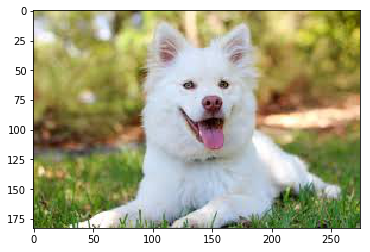

You most definately are a ...
American_eskimo_dog !!

 ------- 

Hello dog,


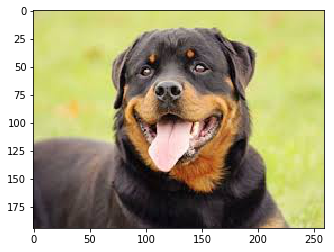

You most definately are a ...
Beauceron !!

 ------- 

No humans or dogs were found in the picture! Try again with another picture.

 ------- 

Hello human,


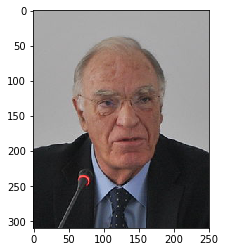

You look like a ...
Bearded_collie !!

 ------- 

Hello human,


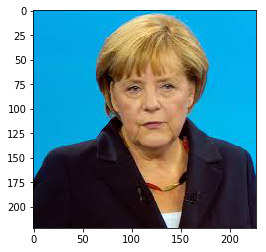

You look like a ...
Bearded_collie !!

 ------- 

Hello dog,


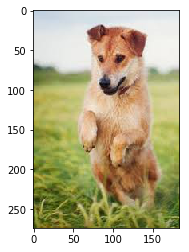

You most definately are a ...
Canaan_dog !!

 ------- 

Hello dog,


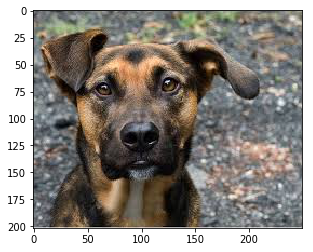

You most definately are a ...
Doberman_pinscher !!

 ------- 

Hello dog,


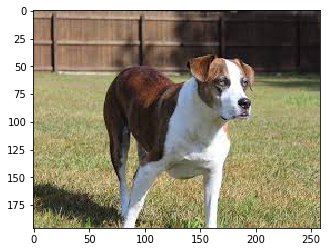

You most definately are a ...
American_staffordshire_terrier !!

 ------- 

Hello dog,


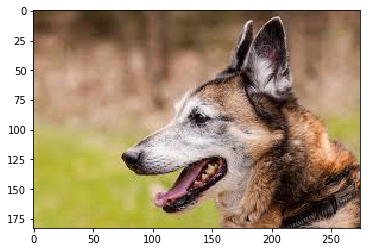

You most definately are a ...
Canaan_dog !!
 and Australian_cattle_dog.

 ------- 

Hello dog,


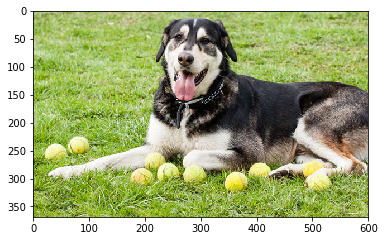

You most definately are a ...
Australian_cattle_dog !!
 and Anatolian_shepherd_dog.

 ------- 

Hello human,


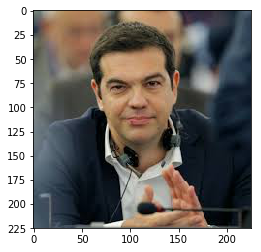

You look like a ...
Bearded_collie !!

 ------- 



In [45]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# get the paths and filenames
file_names = np.array(glob("imagesTest/*"))

# test the algorithm with each of the images
for img_name in file_names:
    look_like_breed(img_name)
    print('\n ------- \n')